## 1. Configuration

In [1]:
import  numpy               as      np
import  torch
from    torch               import  nn
from    torch.utils.data    import  DataLoader

from    utils           import  *
from    models          import  *
from    dataloaders     import  *

from    tqdm.notebook   import  trange
from    matplotlib      import  pyplot  as  plt

device = torch.device(f'cuda:2')

In [2]:
BATCH_SIZE      = 1024
LR              = 1e-3
LR_AE           = 1e-3
LR_MILESTONES   = [50]
NUM_EPOCHS      = 75
NUM_EPOCHS_AE   = 150
WEIGHT_DECAY    = 5e-7
WEIGHT_DECAY_AE = 5e-3

NORMAL_CLASS    = [0]

## 2. Pretrain the encoder

In [3]:
train_dataset   = Dataset_MNIST(BASE_PATHS[MNIST]/"train.npz", NORMAL_CLASS)
test_dataset    = Dataset_MNIST(BASE_PATHS[MNIST]/"test.npz",  NORMAL_CLASS)
train_loader    = DataLoader(train_dataset, BATCH_SIZE)
test_loader     = DataLoader(test_dataset, BATCH_SIZE)

In [4]:
model_ae        = Autoencoder_MNIST(device)
mse_loss_ae     = torch.nn.MSELoss(reduction="mean")
optimizer_ae    = torch.optim.Adam(model_ae.parameters(), LR_AE, weight_decay=WEIGHT_DECAY_AE)
scheduler_ae    = torch.optim.lr_scheduler.MultiStepLR(optimizer_ae, LR_MILESTONES, gamma=0.1)
list_loss_ae:   list[float] = []

print(f"Initiate the training of the autoencoder")
model_ae.train()
for epoch in trange(1, 1+NUM_EPOCHS_AE):
    avg_loss_ae = 0
    for data, _ in train_loader:
        data = data.to(device)
        
        reconst = model_ae.forward(data)
        loss_ae = mse_loss_ae.forward(reconst, data)
        optimizer_ae.zero_grad()
        loss_ae.backward()
        optimizer_ae.step()
        
        avg_loss_ae += loss_ae.item()*data.size(0)
    avg_loss_ae /= len(train_dataset)
    list_loss_ae.append(avg_loss_ae)
    scheduler_ae.step()
    
    if epoch%5==0 or epoch==1:
        print(f"Epoch {epoch:03d} >>> Train loss {avg_loss_ae:.4e}")
list_loss_ae = torch.tensor(list_loss_ae)
print(f"Finished the training of the autoencoder")

Initiate the training of the autoencoder


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 001 >>> Train loss 1.3912e-01
Epoch 005 >>> Train loss 6.7273e-02
Epoch 010 >>> Train loss 5.2565e-02
Epoch 015 >>> Train loss 4.2815e-02
Epoch 020 >>> Train loss 3.3585e-02
Epoch 025 >>> Train loss 2.6977e-02
Epoch 030 >>> Train loss 2.2912e-02
Epoch 035 >>> Train loss 2.0532e-02
Epoch 040 >>> Train loss 1.9040e-02
Epoch 045 >>> Train loss 1.7923e-02
Epoch 050 >>> Train loss 1.7516e-02
Epoch 055 >>> Train loss 1.6307e-02
Epoch 060 >>> Train loss 1.6140e-02
Epoch 065 >>> Train loss 1.6044e-02
Epoch 070 >>> Train loss 1.5953e-02
Epoch 075 >>> Train loss 1.5864e-02
Epoch 080 >>> Train loss 1.5774e-02
Epoch 085 >>> Train loss 1.5685e-02
Epoch 090 >>> Train loss 1.5595e-02
Epoch 095 >>> Train loss 1.5506e-02
Epoch 100 >>> Train loss 1.5417e-02
Epoch 105 >>> Train loss 1.5328e-02
Epoch 110 >>> Train loss 1.5241e-02
Epoch 115 >>> Train loss 1.5155e-02
Epoch 120 >>> Train loss 1.5072e-02
Epoch 125 >>> Train loss 1.4992e-02
Epoch 130 >>> Train loss 1.4913e-02
Epoch 135 >>> Train loss 1.4

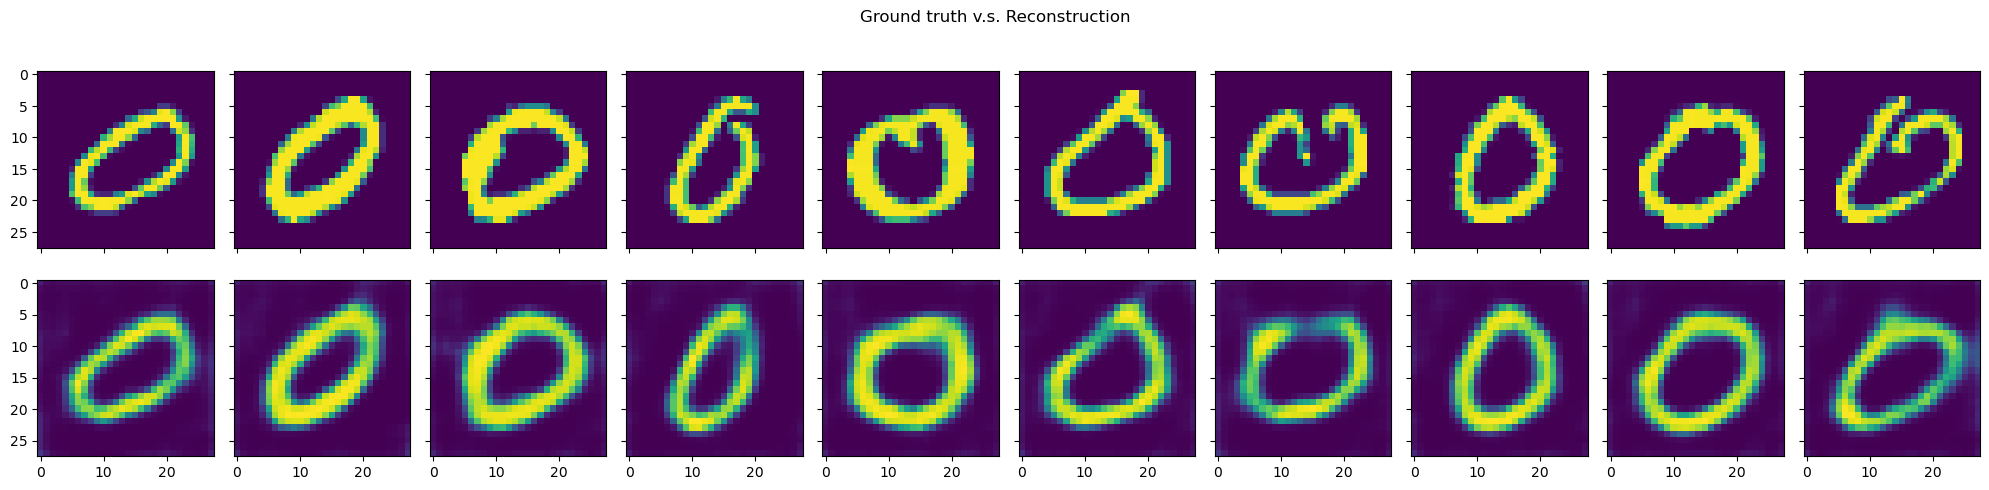

In [5]:
reconstruction = []
model_ae.eval()
with torch.inference_mode():
    for data, _ in test_loader:
        data = data.to(device)
        reconst = model_ae.forward(data).detach().cpu()
        reconstruction.append(reconst)
reconstruction = torch.cat(reconstruction, dim=0)


fig, axes = plt.subplots(2, 10, figsize=(20, 5), sharex=True, sharey=True)
fig.suptitle("Ground truth v.s. Reconstruction")

indices = torch.randint(0, len(test_dataset), (10,))
for c, idx in enumerate(indices):
    axes[0][c].imshow(test_dataset[idx][0].squeeze())
    axes[1][c].imshow(reconstruction[idx].squeeze())
fig.tight_layout()
fig.show()

In [6]:
model_ae.cpu()
torch.save(model_ae.state_dict(), "deep_svdd__pretrained_model.pth")
del(train_dataset, train_loader, test_dataset, test_loader)

## 3. Train and test Deep SVDD

In [7]:
train_dataset   = Dataset_MNIST(BASE_PATHS[MNIST]/"train.npz", NORMAL_CLASS)
test_dataset    = Dataset_MNIST(BASE_PATHS[MNIST]/"test.npz")
train_loader    = DataLoader(train_dataset, BATCH_SIZE)
test_loader     = DataLoader(test_dataset, BATCH_SIZE)

In [8]:
model       = DeepSVDD(model_ae.encoder, nu=5e-2, C=1e-3, is_soft_boundary=False, device=device)
optimizer   = torch.optim.Adam(model.parameters(), LR, weight_decay=WEIGHT_DECAY)
scheduler   = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=LR_MILESTONES, gamma=0.1)
list_loss:  list[float] = []

model.initialize_center(dataloader=train_loader)

model.train()
for epoch in trange(1, 1+NUM_EPOCHS):
    avg_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        loss = model.compute_loss__one_class(data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()*data.size(0)
    avg_loss /= len(train_dataset)
    list_loss.append(avg_loss)
    scheduler.step()
    
    if epoch%5==0 or epoch==1:
        print(f"Epoch {epoch:03d} >>> Train loss {avg_loss:.4e}")
list_loss = torch.tensor(list_loss)

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 001 >>> Train loss 2.1261e-01
Epoch 005 >>> Train loss 1.5003e-02
Epoch 010 >>> Train loss 4.7143e-03
Epoch 015 >>> Train loss 3.0838e-03
Epoch 020 >>> Train loss 2.3575e-03
Epoch 025 >>> Train loss 1.9792e-03
Epoch 030 >>> Train loss 1.7428e-03
Epoch 035 >>> Train loss 1.5604e-03
Epoch 040 >>> Train loss 1.4197e-03
Epoch 045 >>> Train loss 1.3053e-03
Epoch 050 >>> Train loss 1.2067e-03
Epoch 055 >>> Train loss 1.0274e-03
Epoch 060 >>> Train loss 1.0155e-03
Epoch 065 >>> Train loss 1.0060e-03
Epoch 070 >>> Train loss 9.9711e-04
Epoch 075 >>> Train loss 9.8805e-04


In [9]:
model.eval()
prediction = []
ground_truth = []
model.eval()
with torch.inference_mode():
    for data, target in test_loader:
        is_normal = (target.unsqueeze(-1)==torch.tensor(NORMAL_CLASS, dtype=target.dtype)).any(dim=-1)
        _gt     = torch.where(is_normal, 0, 1).cpu()
        _pred   = model.anomaly_score(data.to(device)).cpu()
        ground_truth.append(_gt)
        prediction.append(_pred)
prediction   = torch.cat(prediction, dim=0)
ground_truth = torch.cat(ground_truth, dim=0)

auc_score = roc_auc_score(prediction, ground_truth)
print(f"AUC ROC score >>> {auc_score:.4f}")

AUC ROC score >>> 0.9653


End of file